In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings
from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.plot import heatmap
from graspy.utils import symmetrize
from joblib import Parallel, delayed
from scipy.stats import (
    ttest_ind,
    wilcoxon,
    mannwhitneyu,
    multiscale_graphcorr,
)

from src import generate_truncnorm_sbms  # , compute_pr_at_k

warnings.filterwarnings("ignore")
%matplotlib inline

/env/miniconda3/envs/dnd/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
def compute_statistic(test, pop1, pop2):
    if test.__name__ == "ttest_ind":
        test_statistics, pvals = ttest_ind(pop1, pop2, axis=0)
        np.nan_to_num(test_statistics, copy=False)
        np.nan_to_num(pvals, copy=False)
    else:  # for other tests, do by edge
        n = pop1.shape[-1]
        test_statistics = np.zeros((n, n))
        pvals = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                x_ij = pop1[:, i, j]
                y_ij = pop2[:, i, j]

                if test.__name__ == "multiscale_graphcorr":
                    tmp, pval, _ = test(x=x_ij, y=y_ij, is_twosamp=True, reps=1)
                else:
                    tmp, pval = test(x=x_ij, y=y_ij)

                test_statistics[i, j] = tmp
                pvals[i, j] = pval

        test_statistics = symmetrize(test_statistics, method="triu")
        pvals = symmetrize(pvals, method="triu")

    return test_statistics, pvals

<IPython.core.display.Javascript object>

In [4]:
def compute_pr_at_k(pvalues, k, true_labels):
    """
    Computes precision and recall at various k. 

    Parameters
    ----------
    pvalues : 2d-array like, shape (n, n)
        P-values obtained from some test.
    k : int or array-like
        Values @k to compute precision and recall for. If list, compute P/R for
        each value in list. Otherwise, it computes P/R from range(1, k+1).
    true_labels : 1d-array with shape (n,)
        True community assignments.

    Returns
    -------
    precisions, recalls : array-like
        Computed precisions and recalls.
    """
    label_matrix = np.zeros((len(true_labels), len(true_labels)))
    c1 = (true_labels == 0).sum()
    label_matrix[:c1, :c1] = 1

    triu_idx = np.triu_indices_from(pvalues, k=1)
    labels_vec = label_matrix[triu_idx]
    pvals_vec = pvalues[triu_idx]

    idx = np.argsort(pvals_vec)[::-1]
    sorted_labels = labels_vec[idx]

    if isinstance(k, int):
        ks = range(1, k + 1)
    else:
        ks = k

    precisions = [sorted_labels[:k].mean() for k in ks]
    recalls = [sorted_labels[:k].sum() / sorted_labels.sum() for k in ks]

    return precisions, recalls

<IPython.core.display.Javascript object>

In [5]:
def run_experiment(m, block_1, block_2, mean_1, mean_2, var_1, var_2, ks, reps):
    tests = [multiscale_graphcorr]

    precisions = []
    recalls = []

    for i in range(reps):
        tmp_precisions = []
        tmp_recalls = []
        pop1, pop2, true_labels = generate_truncnorm_sbms(
            m=m,
            block_1=block_1,
            block_2=block_2,
            mean_1=mean_1,
            mean_2=mean_2,
            var_1=var_1,
            var_2=var_2,
        )

        for test in tests:
            test_statistics, pvals = compute_statistic(test, pop1, pop2)
            precision, recall = compute_pr_at_k(test_statistics, ks, true_labels)
            tmp_precisions.append(precision)
            tmp_recalls.append(recall)

        precisions.append(tmp_precisions)
        recalls.append(tmp_recalls)

    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)

    to_append = [m, mean_1, mean_2, var_1, var_2, *precisions, *recalls]

    return to_append

<IPython.core.display.Javascript object>

In [6]:
spacing = 50
block_1 = 5
block_2 = 15

mean_1 = 0
mean_2 = 0
var_1 = 1 / 2
var_2s = np.linspace(var_1, 3, spacing + 1)

ms = np.linspace(0, 500, spacing + 1).astype(int)[1:]
ks = range(5, 11)

reps = 100

<IPython.core.display.Javascript object>

In [7]:
partial_func = partial(
    run_experiment,
    block_1=block_1,
    block_2=block_2,
    mean_1=mean_1,
    mean_2=mean_2,
    var_1=var_1,
    ks=ks,
    reps=reps,
)


args = [dict(m=m, var_2=var_2) for (m, var_2) in product(ms, var_2s)]

res = Parallel(n_jobs=-1, verbose=1)(delayed(partial_func)(**arg) for arg in args)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed: 90.0min
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed: 300.7min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed: 926.6min
[Parallel(n_jobs=-1)]: Done 2258 tasks      | elapsed: 2175.8min
[Parallel(n_jobs=-1)]: Done 2550 out of 2550 | elapsed: 2889.2min finished


<IPython.core.display.Javascript object>

In [21]:
cols = [
    "m",
    "mean1",
    "mean2",
    "var_1",
    "var_2",
    *[
        f"{test.__name__}_precision_at_{k}"
        for test in [multiscale_graphcorr]
        for k in ks
    ],
    *[f"{test.__name__}_recall_at_{k}" for test in [multiscale_graphcorr] for k in ks],
]
res_df = pd.DataFrame(new_res, columns=cols)

<IPython.core.display.Javascript object>

In [22]:
res_df.to_csv("./results/20200209_changing_variances_results.csv", index=False)

<IPython.core.display.Javascript object>

In [23]:
res_df

,m,mean1,mean2,var_1,var_2,multiscale_graphcorr_precision_at_5,multiscale_graphcorr_precision_at_6,multiscale_graphcorr_precision_at_7,multiscale_graphcorr_precision_at_8,multiscale_graphcorr_precision_at_9,multiscale_graphcorr_precision_at_10,multiscale_graphcorr_recall_at_5,multiscale_graphcorr_recall_at_6,multiscale_graphcorr_recall_at_7,multiscale_graphcorr_recall_at_8,multiscale_graphcorr_recall_at_9,multiscale_graphcorr_recall_at_10
0,10,0,0,0.5,0.50,0.062,0.056667,0.061429,0.06125,0.058889,0.057,0.031,0.034,0.043,0.049,0.053,0.057
1,10,0,0,0.5,0.55,0.040,0.045000,0.047143,0.04750,0.044444,0.045,0.020,0.027,0.033,0.038,0.040,0.045
2,10,0,0,0.5,0.60,0.074,0.068333,0.067143,0.06125,0.060000,0.063,0.037,0.041,0.047,0.049,0.054,0.063
3,10,0,0,0.5,0.65,0.060,0.066667,0.062857,0.06000,0.054444,0.057,0.030,0.040,0.044,0.048,0.049,0.057
4,10,0,0,0.5,0.70,0.060,0.058333,0.061429,0.06125,0.061111,0.059,0.030,0.035,0.043,0.049,0.055,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,500,0,0,0.5,2.80,1.000,1.000000,1.000000,1.00000,1.000000,1.000,0.500,0.600,0.700,0.800,0.900,1.000
2546,500,0,0,0.5,2.85,1.000,1.000000,1.000000,1.00000,1.000000,1.000,0.500,0.600,0.700,0.800,0.900,1.000
2547,500,0,0,0.5,2.90,1.000,1.000000,1.000000,1.00000,1.000000,1.000,0.500,0.600,0.700,0.800,0.900,1.000
2548,500,0,0,0.5,2.95,1.000,1.000000,1.000000,1.00000,1.000000,1.000,0.500,0.600,0.700,0.800,0.900,1.000


<IPython.core.display.Javascript object>

# Figures

In [10]:
res_df = pd.read_csv("./results/20200204_diverging_means_results.csv")

<IPython.core.display.Javascript object>

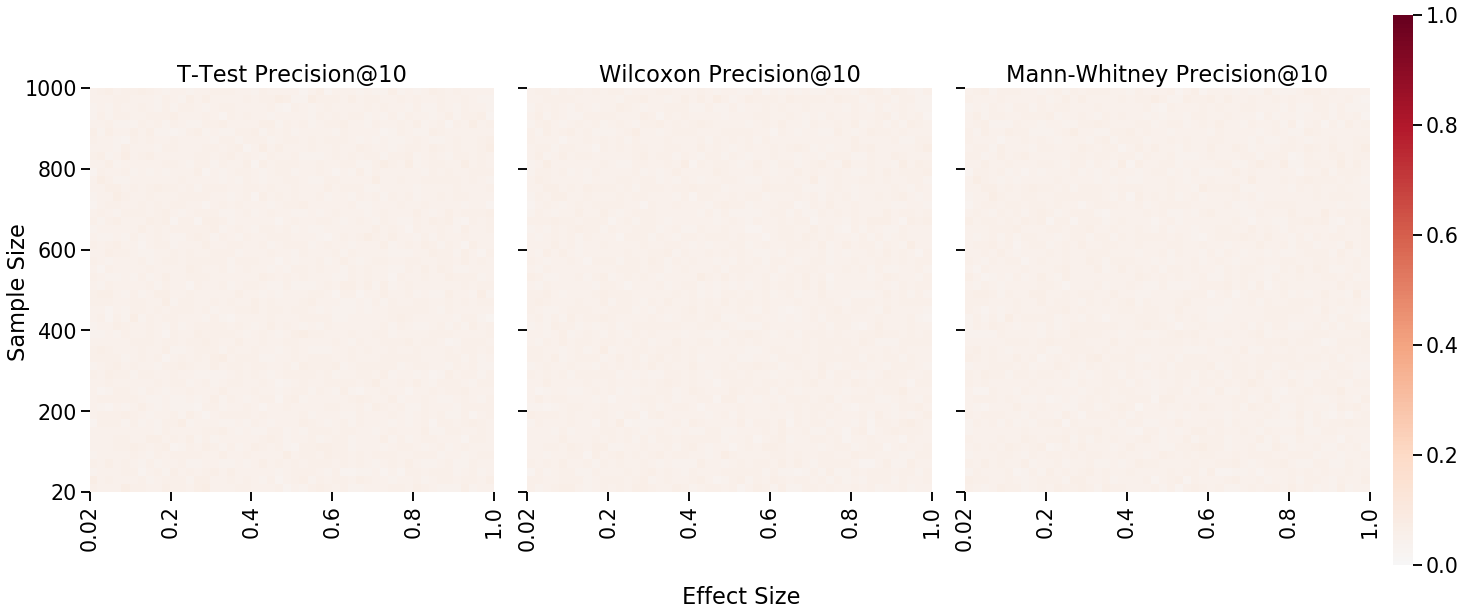

<IPython.core.display.Javascript object>

In [20]:
size = np.sqrt(res_df.shape[0]).astype(int)

ttest_prec = np.flipud(res_df.ttest_ind_precision_at_10.values.reshape(-1, size))
wilcoxon_prec = np.flipud(res_df.wilcoxon_precision_at_10.values.reshape(-1, size))
mannwhitney_prec = np.flipud(
    res_df.mannwhitneyu_precision_at_10.values.reshape(-1, size)
)

vmin = 0
vmax = 1

p = 0.5
spacing = 50
deltas = np.linspace(0, 1, spacing + 1)[::10]
deltas[0] += 0.02
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20

fmt = lambda x: "{:.2f}".format(x)
ms = ["{:.0f}".format(m) for m in ms][::-1]

with sns.plotting_context("talk", font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(20, 8),
        constrained_layout=True,
    )

    sns.heatmap(
        ttest_prec,
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        yticklabels=ms,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10))
    ax[0].set_title("T-Test Precision@10")

    sns.heatmap(
        wilcoxon_prec,
        ax=ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("Wilcoxon Precision@10")

    sns.heatmap(
        mannwhitney_prec,
        ax=ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Mann-Whitney Precision@10")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Effect Size", va="center", ha="center")

    fig.savefig("./figures/20200204_precision.png", dpi=300, bbox_inches="tight")
    fig.savefig("./figures/20200204_precision.pdf", dpi=300, bbox_inches="tight")